### Blockchain Token Time Series Forcast Analysis 

This program uses a supervised machine learning model XGBoost Regression to predict the closing price of a blockchain token (Decentraland MANA). 

In [2]:
#Import dependencies
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
#Load data
df = pd.read_csv('MANA-USD (1).csv', parse_dates=True,  index_col="Date")
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.014329,0.016111,0.013886,0.015130,0.015130,653800
2017-11-10,0.015162,0.015734,0.012645,0.012940,0.012940,296429
2017-11-11,0.013201,0.013616,0.011758,0.011979,0.011979,237865
2017-11-12,0.011975,0.011975,0.010125,0.010505,0.010505,242761
2017-11-13,0.010628,0.011660,0.010628,0.011330,0.011330,225836


In [4]:
df.shape

(1710, 6)

In [5]:
df.isnull().values.any()

False

### Visualize the data

#### Closing price history

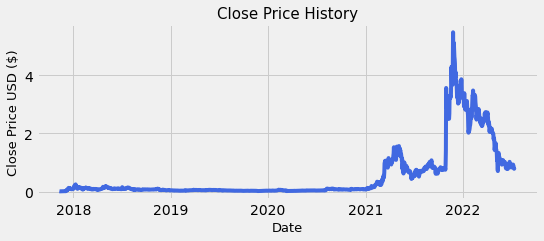

In [6]:
plt.figure(figsize=(8,3))
plt.title('Close Price History',fontsize=15)
plt.plot(df.Close, color='royalblue')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Close Price USD ($)', fontsize=13)
plt.show()

In [7]:
highest_close_price = df.Close.argmax() 

date = df.index[highest_close_price].date()

df.iloc[highest_close_price ], date

(Open         5.161565e+00
 High         5.902317e+00
 Low          4.691721e+00
 Close        5.479181e+00
 Adj Close    5.479181e+00
 Volume       1.028121e+10
 Name: 2021-11-25 00:00:00, dtype: float64,
 datetime.date(2021, 11, 25))

#### The closing price peaked on November 25th , 2021, then started to drop significantly in 2022 due to upcoming possible recession and inflation.

### When did a holder get the highest returns?
Return = (Close - Open) / Open

In [8]:
df_returns = (df['Close'] - df['Open']) / df['Open']
df_returns = pd.DataFrame(df_returns, columns=['Return'])
df_returns.head()

,Return
Date,
2017-11-09,0.055901
2017-11-10,-0.146551
2017-11-11,-0.092569
2017-11-12,-0.122756
2017-11-13,0.066052


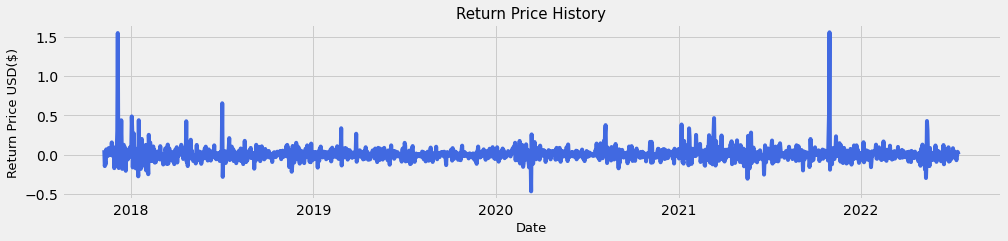

In [9]:
plt.figure(figsize=(15,3))
plt.title('Return Price History',fontsize=15)
plt.plot(df_returns.Return, color='royalblue')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Return Price USD($)', fontsize=13)
plt.show()

In [10]:
highest_return_price = df_returns.Return.argmax() 

date = df.index[highest_return_price].date()

df_returns.iloc[highest_close_price ], date

(Return    0.061535
 Name: 2021-11-25 00:00:00, dtype: float64,
 datetime.date(2021, 10, 30))

#### The highest return was on October 30th 2021.

### Transform to supervised learning problem

Set target to be the next day's close price

In [11]:
df = df.filter(['Close'])
df.head(5)

,Close
Date,
2017-11-09,0.015130
2017-11-10,0.012940
2017-11-11,0.011979
2017-11-12,0.010505
2017-11-13,0.011330


In [12]:
df['Target'] = df.Close.shift(-1)
df.dropna(inplace=True)
df.head()

,Close,Target
Date,,
2017-11-09,0.015130,0.012940
2017-11-10,0.012940,0.011979
2017-11-11,0.011979,0.010505
2017-11-12,0.010505,0.011330
2017-11-13,0.011330,0.011419


#### Train / Test Split

In [13]:
def train_test_split(data, split):
    data = data.values
    n = int(len(data)*(1-split))
    return data[:n], data[n:]


In [14]:
train, test = train_test_split(df, 0.2)

In [15]:
X_train, y_train = train[:, :-1], train[: , -1]
test_X, test_y = test[:, :-1], test[: , -1]

#### Build Model

In [16]:
model = xgb.XGBRegressor(objective='reg:squarederror',nthread = 4)

params = {
        'n_estimators' :  [100, 200, 300, 400],
        'eta': [0.05, 0.001, 0.1, 0.2, 0.15, 0.25, 0.3, 0.4],
        'max_depth': [8, 10, 12, 15],
        'subsample': [0.9, 1.0, 0.8, 0.5, 0.3, 0.4, 0.7, 0.75],
        'colsample_bytree': [0.9, 1.0, 0.8, 0.85],
        'alpha': [0.1, 0.3, 0.0, 0.4],
        'gamma' : [0.001, 0.005, 0.01, 0.02],
        'learning_rate' : [0.001, 0.005, 0.01, 0.05],
        'lambda' : [1, 1.5, 2, 2.5, 0.5, 2, 2.3, 2.5, 3],
        'random_state': [42]
   }

random_search = RandomizedSearchCV(model, params, n_jobs=-1, cv=5, n_iter=100, scoring='r2')

In [17]:
random_search.fit(X_train, y_train, verbose=True)

best_parameters = random_search.best_params_

In [18]:
#Results

print('Model Score: '+ '\n')
print(round(random_search.best_score_, 2))
print('\n')
print('Best Parameters: ' +'\n')

for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))


print(' ')
print('Best Estimator: ')
print(random_search.best_estimator_)

Model Score: 

0.62


Best Parameters: 

alpha: 0.0
colsample_bytree: 1.0
eta: 0.05
gamma: 0.001
lambda: 2
learning_rate: 0.05
max_depth: 15
n_estimators: 400
random_state: 42
subsample: 0.8
 
Best Estimator: 
XGBRegressor(alpha=0.0, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, gamma=0.001, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', lambda=2,
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=4,
             nthread=4, num_parallel_tree=1, ...)


In [19]:
y_pred = random_search.predict(test_X)

y_pred[:5]

array([0.78148234, 0.6936821 , 0.74280924, 0.86208683, 0.867994  ],
      dtype=float32)

In [20]:
test_y[:5]

array([0.719177, 0.753815, 0.828038, 0.823656, 0.800826])

In [21]:
#import matplotlib.pyplot as plt
#plt.figure(figsize=(16,8))
#plt.title('Model')
#plt.xlabel('Date',fontsize=18)
#plt.ylabel('Close Price USD ($)', fontsize=18)
#plt.plot(y_pred)
#plt.plot(test_y)
#plt.legend(['Predictions', 'Validation'],loc='upper right')
#plt.show()